# ASR decoder 

Example how to build an ASR decoder. We consider a decoder with the following lexicon:

|  Word | Pronunciation | 
|:-----:|:--------------|
| zero  | z e r o       |
| one   | o n e         |            
| two   | t w o         |
| three | t h r e e     |
| three | s r e e       |
| four  | f o u r       |
| five  | f i v e       |
| six   | s i x         |
| seven | s e v e n     |
| eight | e i g h t     |
| nine  | n i n e       |
 
Note that, for simplicity, we use the letters as phones. Also, every word has a single pronunciation except "three" which can be pronunced "three" and "sree".  

In [1]:
using Pkg
Pkg.activate("../")

using Revise
using MarkovModels

SF = ProbabilitySemiField{Float64}

 Activating environment at `~/GithubRepositories/MarkovModels.jl/Project.toml`
┌ Info: Precompiling MarkovModels [c2ae6250-d0a1-11ea-0991-234599ce5244]
└ @ Base loading.jl:1278


MarkovModels.SemiField{Float64,+,*,/,0,1}

## HMMs

We build an HMM each phone (in this case letters). Each phone is modeled by a 3-state left-to-right HMM.

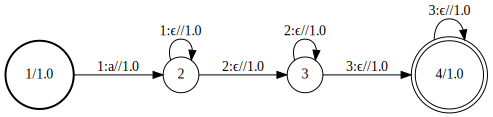

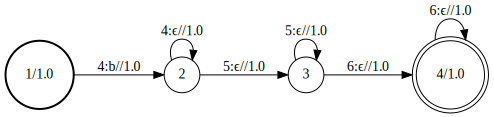

In [2]:
function makehmm(l, pdfidxs)
    fsm = FSM{SF}()
    prevstate = addstate!(fsm)
    setstart!(prevstate)
    olabel = l
    for pdfidx in pdfidxs
        state = addstate!(fsm)
        link!(fsm, state, state, ilabel = "$pdfidx")
        link!(fsm, prevstate, state, ilabel = "$pdfidx", olabel = olabel)
        prevstate = state
        olabel = nothing
    end
    setfinal!(prevstate)
    
    fsm 
end

hmms = Dict()
countpdfs = 0
for (i, l) in enumerate('a':'z')
    startidx = 3 * (i -1) + 1
    countpdfs += 3
    hmms["$l"] = makehmm("$l", [startidx, startidx + 1, startidx + 2])
end

phones = collect('a':'z')

display(hmms["a"])
display(hmms["b"])

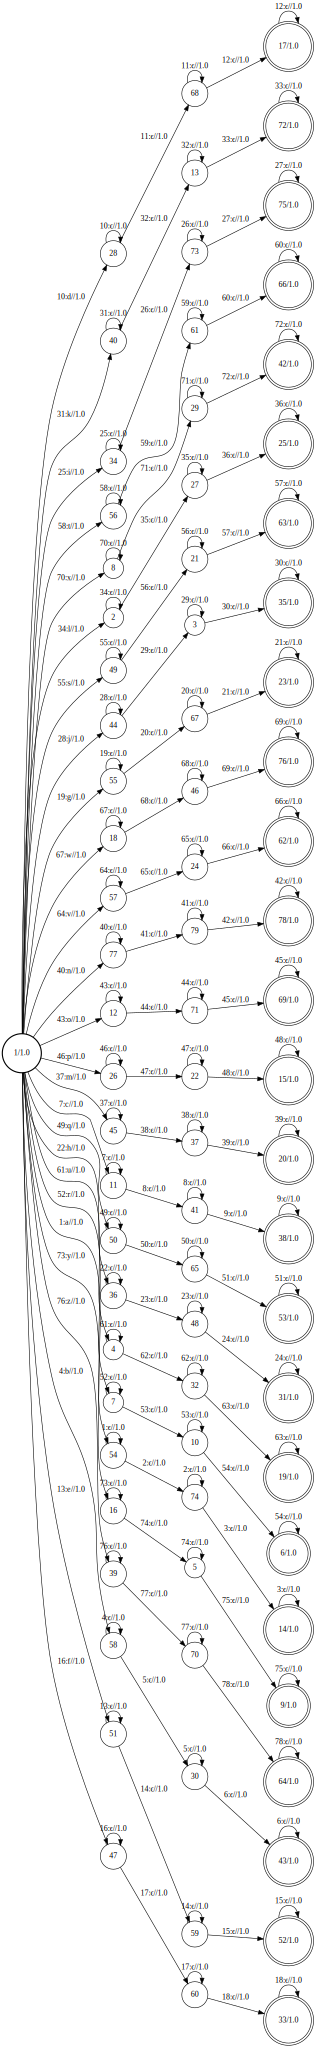

In [16]:
H = ∪(collect(values(hmms))...) 

## Lexicon

Now we build the FSM lexicon

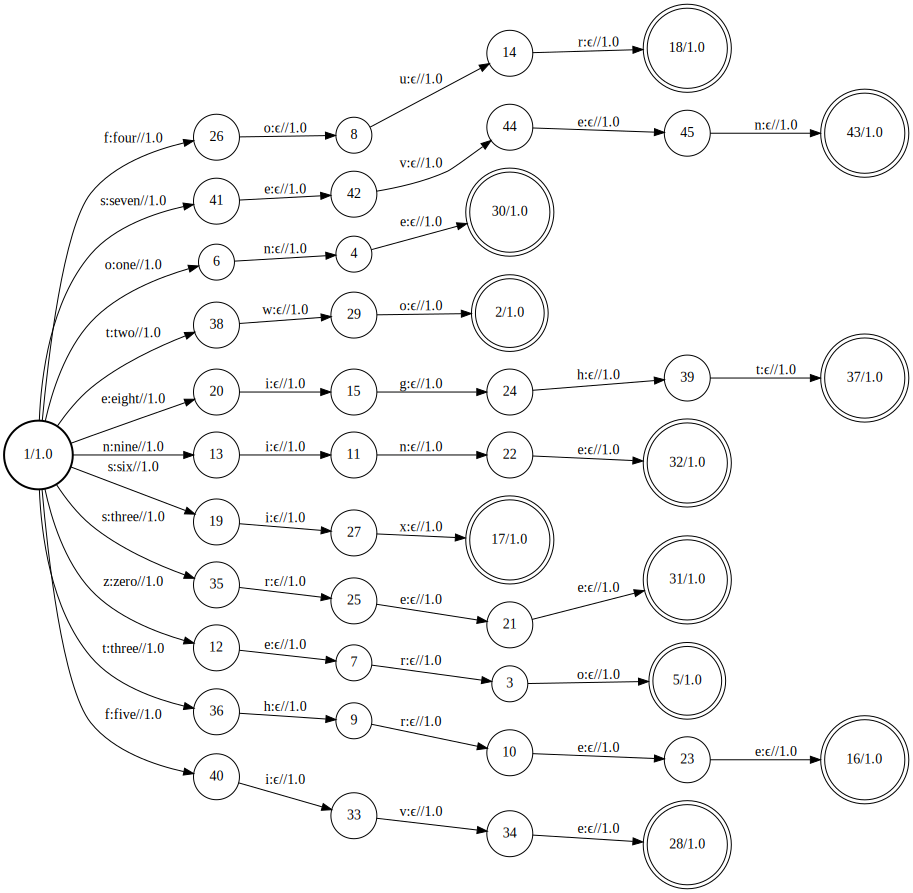

In [13]:
raw_lexicon = Dict(
    "zero"  => [("z", "e", "r", "o")],
    "one"   => [("o", "n", "e")],
    "two"   => [("t", "w", "o")],
    "three" => [("t", "h", "r", "e", "e"),
                ("s", "r", "e", "e")],  
    "four"  => [("f", "o", "u", "r")],
    "five"  => [("f", "i", "v", "e")],
    "six"   => [("s", "i", "x")],
    "seven" => [("s", "e", "v", "e", "n")],
    "eight" => [("e", "i", "g", "h", "t")],
    "nine"  => [("n", "i", "n", "e")]
)

function makepronunciation(word, pronunciation)
    fsm = FSM{SF}()
    
    prevstate = addstate!(fsm)
    setstart!(prevstate)
    for phone in pronunciation
        state = addstate!(fsm)
        if isinit(prevstate)
            link!(fsm, prevstate, state, ilabel = phone, olabel = word)
        else
            link!(fsm, prevstate, state, ilabel = phone)
        end
        prevstate = state
    end
    setfinal!(prevstate)
    
    fsm
end


L = ∪([∪(makepronunciation.([word], pronunciations)...) for (word, pronunciations) in raw_lexicon]...)
#∪(makepronunciation.(["three"], raw_lexicon["three"])...) |> minimize


## Language Model

We simply assume a flat unigram language model

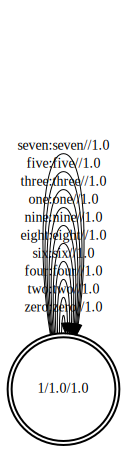

In [14]:
words = keys(raw_lexicon)

# Create a simple unigram language model
G = FSM{SF}()
s = addstate!(G)
setstart!(s)
setfinal!(s)

for word in words
    link!(G, s, s, ilabel = word, olabel = word)
end
G

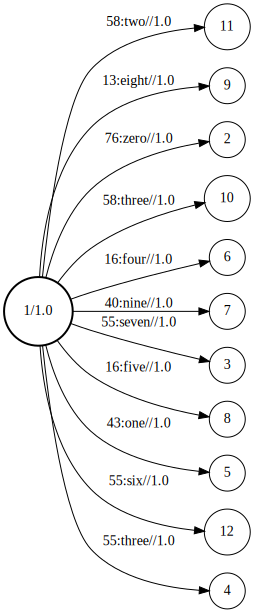

In [17]:
H ∘ L ∘ G 

## Generating a lattice

In [19]:
D,N = countpdfs, 100 # number of distributions times number of frames
llh = randn(D, N)

78×100 Array{Float64,2}:
  0.447532    0.0708151   1.4526     …   1.52439     1.67068     -0.523469
  0.984683   -1.08458     1.19129        0.439921   -0.494727    -0.252112
  0.524388   -0.345133    0.407909       0.186491    1.30557      0.393869
 -0.0807942  -0.85628    -2.30021        1.19585    -1.24905     -2.00025
 -0.728437   -1.99691    -0.0263262     -0.613612   -0.230909     0.177701
  0.365361    0.296079   -1.28943    …   1.93442    -0.612211     0.0260747
 -1.05278    -0.849239   -1.00927       -0.809609    0.717981     0.993183
  0.0198603  -0.473816   -0.539369       0.582425   -0.519209    -0.891476
  1.07204     0.393806   -0.481655       0.288709   -0.626598    -2.35713
  0.629357   -1.72289     1.14019        1.5094     -1.64487      0.409797
 -0.754374   -0.477309   -0.260885   …  -2.5705      0.466448     1.66859
 -0.219883   -0.169682    1.29779       -0.0243511  -1.97614      0.495603
  1.74313     0.189301    0.186199      -0.573769   -1.63739      0.500796
  

## Decoding 
### Word level

In [81]:
π_best = beststring(decoder, llh, labelfilter = x -> x ∈ keys(lexicon))
join(π_best, " ")

"eight five three five"

### Phone level

In [85]:
π_best = beststring(decoder, llh, labelfilter = x -> x ∈ keys(hmms))
join(π_best, " ")

"e i g h t f i v e s r e e f i v e"

## Sampling path

It is also possible to sample path given the data

### Sampling words

In [86]:
paths = samplestring(decoder, llh, nsamples = 5, labelfilter = x -> x ∈ keys(lexicon)) 
for path in paths
    display(path)
end

4-element Array{Any,1}:
 "eight"
 "five"
 "three"
 "five"

4-element Array{Any,1}:
 "eight"
 "eight"
 "zero"
 "five"

3-element Array{Any,1}:
 "eight"
 "eight"
 "eight"

5-element Array{Any,1}:
 "zero"
 "zero"
 "zero"
 "one"
 "five"

4-element Array{Any,1}:
 "six"
 "zero"
 "eight"
 "eight"

### Sampling phones

In [87]:
paths = samplestring(decoder, llh, nsamples = 5, labelfilter = x -> x ∈ keys(hmms)) 
for path in paths
    display(path)
end

18-element Array{Any,1}:
 "e"
 "i"
 "g"
 "h"
 "t"
 "e"
 "i"
 "g"
 "h"
 "t"
 "f"
 "o"
 "u"
 "r"
 "f"
 "i"
 "v"
 "e"

21-element Array{Any,1}:
 "z"
 "e"
 "r"
 "o"
 "f"
 "i"
 "v"
 "e"
 "n"
 "i"
 "n"
 "e"
 "e"
 "i"
 "g"
 "h"
 "t"
 "f"
 "i"
 "v"
 "e"

20-element Array{Any,1}:
 "e"
 "i"
 "g"
 "h"
 "t"
 "e"
 "i"
 "g"
 "h"
 "t"
 "t"
 "w"
 "o"
 "s"
 "i"
 "x"
 "f"
 "i"
 "v"
 "e"

15-element Array{Any,1}:
 "e"
 "i"
 "g"
 "h"
 "t"
 "e"
 "i"
 "g"
 "h"
 "t"
 "e"
 "i"
 "g"
 "h"
 "t"

15-element Array{Any,1}:
 "s"
 "i"
 "x"
 "f"
 "i"
 "v"
 "e"
 "s"
 "r"
 "e"
 "e"
 "f"
 "i"
 "v"
 "e"